# QSAR modelling of estrogen receptor alpha ligands

This notebook features a workflow that tries to extract activity-structure information from experimental data. 


## Data Aquisition and Preprocessing

The data are saved in the database (DB) and can be loaded into a [pandas](http://pandas.pydata.org) data frame using the [`compound_db_utils`](https://github.com/martin-sicho/MI_ADM/tree/master/compound_db_utils) package:

In [1]:
import os, pickle, math

from compound_db_utils import settings
from compound_db_utils.data_loaders import fetch_learning_data

SEED = 42
CV_FOLDS = 10
RELOAD = False # if True, ignore the pickled data and update from DB

def remove_inconsistent(smiles, ic50s):
    """
    Filter that computes a consensus value for molecules that were tested
    multiple times. The consensus is computed as the median of all 
    available values. 
    
    Molecules with too much variation in the data 
    and too few data points are marked as inconsistent and
    removed entirely.
    """
    
    if int(math.log(ic50s.min(), 10)) != int(math.log(ic50s.max(), 10)) and len(ic50s) < 20:
        return False
    else:
        return ic50s.median()

data = None
if os.path.exists('data.pickle') and not RELOAD:
    data = pickle.load(open('data.pickle', 'br'))
else:
    data = fetch_learning_data(
                ['MI-T-15c25ba4']
                , col_names_map={
                    settings.COMPOUNDS_TABLE + '_smiles' : 'smiles'
                    , settings.BIOACTIVITIES_TABLE + '_value' : 'ic50'
                }
                , create_rdkit_mols=False
                , compute_descriptors=True
                , duplicates_handler= remove_inconsistent
            )
    
pickle.dump(data, open('data.pickle', 'bw'))

/home/sichom/software/miniconda/envs/MI_ADM/lib/python3.5/site-packages/rdkit/Chem/PeriodicTable.py:131: FutureWarning: split() requires a non-empty pattern match.
  splitLine = blankExpr.split(line)


For each compound, the loaded data provide the canonical [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) string and measured [IC50](https://en.wikipedia.org/wiki/IC50) values. We also chose to compute molecular descriptors for the compounds. Those are saved in the remaining columns (descriptors are computed using the [RDKit](https://rdkit.readthedocs.io/en/latest/) cheminformatics toolkit).

Note that the original dataset may contain duplicate entries, because more experiments were often carried out for one given compound. Here, we decided to remove compounds that show large inconsistencies in their IC50 values and we do not have enough data to safely aggregate the values together.

Next, we convert the IC50 values to pIC50 which is defined as the negative logarithm with base 10 of the concentration in moles rather than nanomoles (the default unit for the data in our database): 

In [2]:
import numpy as np

data.ic50 = data.ic50.apply(lambda x : -1.0 * np.log10(x / 1.0e9))

Because of the logarithmic scale, the converted data are now much 'nicer' (note that the higher the pIC50 value, the more potent the compound is as opposed to the raw IC50 value where lower value means higher potency):

Original:
count       1327.000000
mean       12345.786545
std       126395.212707
min            0.200000
25%           55.500000
50%          625.000000
75%         7308.305000
max      3500000.000000
Name: ic50, dtype: float64

Converted:
count    1327.000000
mean        6.295696
std         1.359669
min         2.455932
25%         5.136184
50%         6.204120
75%         7.255725
max         9.698970
Name: ic50, dtype: float64


[]

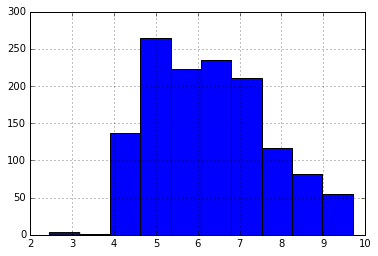

In [3]:
%matplotlib inline
print('Original:')
print(data.ic50.apply(lambda x : np.power(10, - x) * 1.0e9).describe())
print('\nConverted:')
print(data.ic50.describe())
data.ic50.hist().plot()

## Generating the training and testing/validation sets

Now that the dataset is ready, we split the data frame into a training and testing/validation set:

In [4]:
import h2o
from h2o.frame import H2OFrame

def create_frame(data_frame, name):
    frame = H2OFrame.from_python(
        python_obj=data_frame
        , destination_frame=name
        , column_names=data_frame.columns.get_values().tolist()
        , header=1
    )
    return frame

In [ ]:
# from sklearn.cross_validation import train_test_split

# h2o.init()
# h2o.h2o.remove_all()

#  # data structures used in scikit-learn
# data_train, data_test, pIC50_train, pIC50_test = train_test_split(
#     data
#     , data.ic50
#     , test_size=0.4
#     , random_state=SEED
# )
# data_train.head()

#  # data structures used in h2o
# training_frame = create_frame(data_train, "training_frame")
# testing_frame = create_frame(data_test, "testing_frame")
# data_train.set_index('smiles', inplace=True)
# data_test.set_index('smiles', inplace=True)

# print(training_frame.shape, testing_frame.shape)
# print(data_train.shape, data_test.shape)

In [5]:
h2o.init()
h2o.h2o.remove_all()

# data structures used in h2o
frame = create_frame(data, 'frame')
training_frame, testing_frame =  frame.split_frame(
    ratios=[0.6]
    , destination_frames=["data_all_train", "data_all_test"]
    , seed=SEED
)

# data structures used in scikit-learn
data_train = training_frame.as_data_frame()
data_test = testing_frame.as_data_frame()
data_train.set_index('smiles', inplace=True)
data_test.set_index('smiles', inplace=True)

print(training_frame.shape, testing_frame.shape)
print(data_train.shape, data_test.shape)

Connecting to H2O server at http://localhost:54321... successful!


H2O cluster uptime:,1 min 37 secs
H2O cluster version:,3.10.0.3
H2O cluster version age:,8 days
H2O cluster name:,sichom
H2O cluster total nodes:,1
H2O cluster free memory:,1.696 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster is healthy:,True
H2O cluster is locked:,False
H2O connection url:,http://localhost:54321



(811, 198) (516, 198)
(811, 197) (516, 197)


## Building a SVR model with sklearn

In this part of the notebook, we attempt to train an SVR estimator on the data using [scikit-learn](http://scikit-learn.org/).

### Feature Selection

Before we attempt to build the model, we need to remove some variables that might have and adverse effect on the outcome. We will also remove features that will have no effect at all and are therefore irrelevant.

We also define a couple of helper functions that will update our dataset as we go:

In [6]:
def get_removed_feats(data, model):
    """
    This function  finds out the names of the descriptors
    removed by the model.
    """
    
    return data.columns.values[1:][~model.get_support()]

def update_data(data, removed_descriptors, inplace=False):
    """
    Removes the descriptors marked for removal from the data frame.
    """
    if inplace:
        data.drop(removed_descriptors, 1, inplace=True)
        print(data.shape)
        return data
    else:
        new_data = data.drop(removed_descriptors, 1, inplace=False)
        print(new_data.shape)
        return new_data

#### Variance Threshold

In the first step we remove features that have zero variance. In other words, the features that have the same value for all of our compounds:

In [7]:
from sklearn.feature_selection import VarianceThreshold

# find the names of the columns with zero variance
var_sel = VarianceThreshold()
var_sel.fit(data_train.iloc[:,1:])
removed_descriptors = get_removed_feats(data_train, var_sel)

# update the data frame
data_train = update_data(data_train, removed_descriptors)
data_test = update_data(data_test, removed_descriptors)

(811, 197)
(516, 197)


#### Correlation Filter

Next, we remove the features that are highly correlated with others:

In [8]:
correlated_descs = dict()
def find_correlated(data):
    correlation_matrix = data.corr(method='spearman')
    removed_descs = set()
    all_descs = correlation_matrix.columns.values
    for label in all_descs:
        correlations_abs = correlation_matrix[label].abs()
        mask = (correlations_abs > 0.9).values
        correlated_names = all_descs[mask]
        correlated_descs[label] = set(correlated_names)
        correlated_descs[label].remove(label)
        if label not in removed_descs:
            removed_descs.update(correlated_descs[label])
        
    return removed_descs

removed_corr = find_correlated(data_train.iloc[:,1:])
data_train = update_data(data_train, removed_corr)
data_test = update_data(data_test, removed_corr)
pickle.dump(correlated_descs, open('correlated_descs_svr.pickle', 'bw'))

(811, 45)
(516, 45)


In [9]:
final_desc_set = data_train.iloc[:,1:].columns.tolist()
pickle.dump(final_desc_set, open('final_desc_set_svr.pickle', 'bw'))

### Model Building

Because we will be building a SVM model, we need to standardize 
the features first. We do so by removing the mean and scaling to unit variance:

In [10]:
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame, concat

def scale_df(frame, scaler):
    return DataFrame(scaler.transform(frame), columns=frame.columns)

scaler = StandardScaler(copy=False)
scaler.fit(concat( (data_train.iloc[:,1:], data_test.iloc[:,1:]) ))

descriptors_train = scale_df(data_train.iloc[:,1:], scaler)
descriptors_train.index = data_train.index
descriptors_test = scale_df(data_test.iloc[:,1:], scaler)
descriptors_test.index = data_test.index
print(descriptors_train.shape, descriptors_test.shape)
descriptors_train.head()

(811, 44) (516, 44)


,MaxAbsPartialCharge,MaxAbsEStateIndex,NumValenceElectrons,MaxPartialCharge,MinEStateIndex,MinAbsEStateIndex,NumRadicalElectrons,BalabanJ,BertzCT,Chi2n,...,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState9,NHOHCount,NOCount,NumAliphaticHeterocycles,NumAromaticCarbocycles,RingCount,MolLogP
smiles,,,,,,,,,,,,,,,,,,,,,
CC(C)c1cccc(N2CCc3cc(O)ccc3C2(C)c2ccc(OCCN3CCCCC3)cc2)c1,0.495945,-0.713656,1.712185,-1.141200,0.188610,1.723160,-0.095527,-1.069008,0.871272,1.736098,...,-0.405558,3.814130,-0.278917,1.110993,2.878052,-0.640326,0.680331,1.03820,1.177054,1.931418
Cc1ccc(S(=O)(=O)N2CCc3cc(O)ccc3C2c2ccc(OCCN3CCCC3)cc2)cc1,0.495945,1.162143,1.536383,0.345270,-2.705455,0.571983,-0.095527,-1.071815,1.250394,1.954604,...,1.756292,-0.650329,-0.278917,0.000187,-0.325954,0.782183,0.680331,1.03820,1.177054,0.215476
CC1=C(c2ccc(O)cc2)C(=O)c2ccc(O)cc21,0.496109,0.455185,-1.100652,-0.244449,0.458700,-0.635483,-0.095527,0.737782,-0.859221,-1.095170,...,-0.707824,-0.922857,-1.005929,-0.242284,-0.325954,-1.114495,-1.026283,-0.04065,-0.685737,-0.790551
Oc1ccc2c(c1)S[C@H](c1ccco1)[C@H](c1ccc(OCCN3CCCCC3)cc1)O2,0.495365,-0.885555,0.891774,-0.852309,0.325463,-0.613013,-0.095527,-1.412045,0.176579,1.003298,...,0.650491,0.024483,1.126039,0.262669,2.878052,0.308014,-0.172976,-0.04065,1.177054,1.236013
O=c1c2oc3c(Br)cc(O)cc3c2oc2cc(O)cc(O)c12,0.494966,0.513785,-0.631846,0.294030,0.016014,-0.787176,-0.095527,1.087420,0.761888,-0.603665,...,-1.109591,-0.036848,0.349957,-0.377394,-0.325954,0.782183,-1.026283,-0.04065,0.245658,-0.519347


Next, we use a grid to optimize the hyperparameters of the model and we select the best model for further evaluation:

In [13]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

param_grid = [
    {
        'C': [1, 10, 100, 1000]
        , 'epsilon': [0.0, 0.1, 0.2, 0.3, 0.4]
        , 'gamma': [1.0, 0.1, 0.01, 0.001]
        , 'kernel': ['rbf']
    },
]

gs = GridSearchCV(SVR(), param_grid, n_jobs=2, cv=CV_FOLDS)
gs.fit(descriptors_train, data_train.ic50)
model = SVR(**gs.best_estimator_.get_params())
gs.best_estimator_.get_params()

{'C': 10,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.0,
 'gamma': 0.01,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Cross-validation Results

Here, we get the cross-validation scores (as the mean coefficient of determination for all folds) and compute the average correlation between the predicted and true values of pIC50:

In [14]:
from sklearn.cross_validation import cross_val_score
import numpy as np

scores = cross_val_score(model, descriptors_train, data_train.ic50, cv=CV_FOLDS)
scores_mse = cross_val_score(model, descriptors_train, data_train.ic50, cv=CV_FOLDS, scoring='mean_squared_error')

print("Mean R^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Mean R: %0.2f (+/- %0.2f)" % (np.sqrt(scores).mean(), np.sqrt(scores).std() * 2))
print("Mean MSE: %0.2f (+/- %0.2f)" % (abs(scores_mse.mean()), scores_mse.std() * 2))

Mean R^2: 0.68 (+/- 0.22)
Mean R: 0.82 (+/- 0.15)
Mean MSE: 0.58 (+/- 0.54)


### Validation Set Results

Finally, we use the trained model to predict the pIC50 values for our test set and use the same metrics as in the above example as well as the mean squared error (MSE) to evaluate the quality of the model:

In [15]:
from sklearn.metrics import mean_squared_error

model.fit(descriptors_train, data_train.ic50)

print("R^2: %0.2f" % model.score(descriptors_test, data_test.ic50))
print("R: %0.2f" % np.sqrt(model.score(descriptors_test, data_test.ic50)))
print("MSE: %0.2f" %  mean_squared_error(model.predict(descriptors_test), data_test.ic50))

R^2: 0.75
R: 0.87
MSE: 0.44


In [16]:
validation_predictions = DataFrame()
validation_predictions['ic50_predicted'] = model.predict(descriptors_test)
validation_predictions['ic50_true'] = data_test.ic50.values
validation_predictions.index = descriptors_test.index
pickle.dump(validation_predictions, open('validation_set_predictions_svr.pickle', 'wb'))
validation_predictions.head()

,ic50_predicted,ic50_true
smiles,,
CCc1c(O)ccc2c1O[C@H](c1ccc(OCCN3CCCCC3)cc1)[C@H](c1ccc(O)cc1)S2,7.867606,8.327902
COc1c(Br)c(O)c(Br)c2nc(-c3ccc(O)c(F)c3)oc12,5.748524,6.252588
Oc1ccc2nc(-c3ccc(O)c(F)c3)cc(Cl)c2c1,6.004725,6.609065
COc1cc(/C=C2\SC(=O)NC2=O)ccc1Oc1ccc(C#N)cc1C(F)(F)F,5.301276,5.657577
CCOC(=O)CSc1nn(C)c(=S)s1,5.018956,5.097820


### Error plots

Finally, we take a look at the distribution of errors in predictions among the training set and the test set:

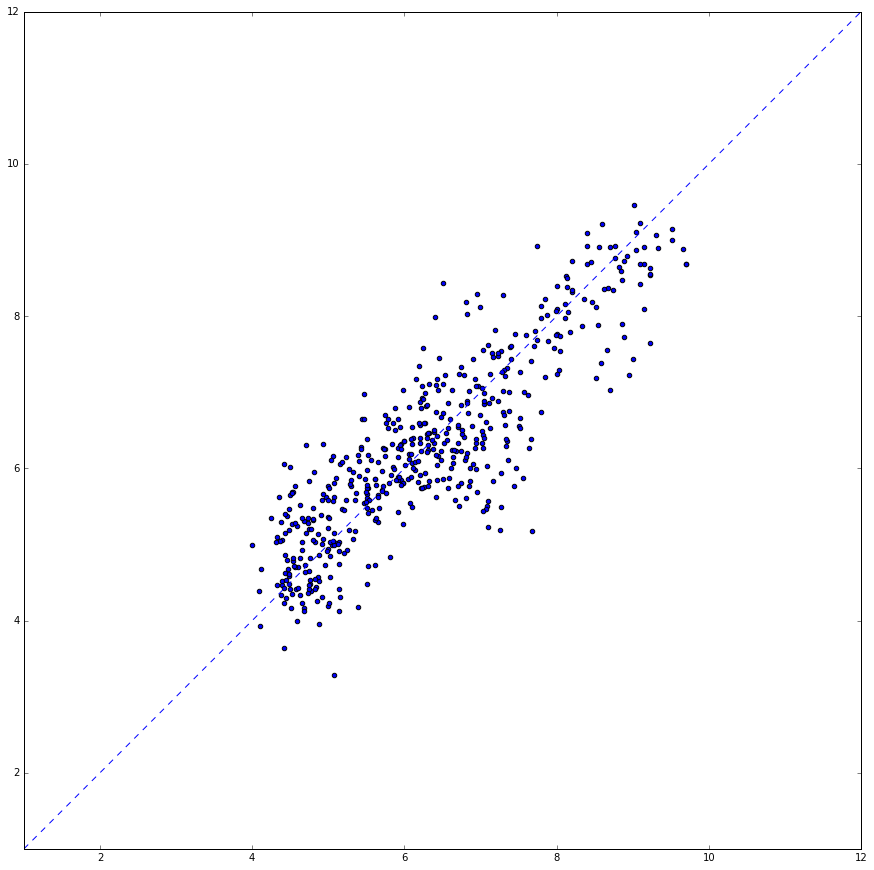

In [17]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 15]
span = (1,12)
axes = plt.gca()
axes.set_xlim(span)
axes.set_ylim(span)

plt.plot((span[0],span[1]), (span[0],span[1]), linestyle='--')

# plt.scatter(
#     pIC50_train
#     , model.predict(descriptors_train)
#     , c='green'
#     , s=20
# )

plt.scatter(
    data_test.ic50
    , model.predict(descriptors_test)
    , c='blue'
    , s=20
)
plt.show()

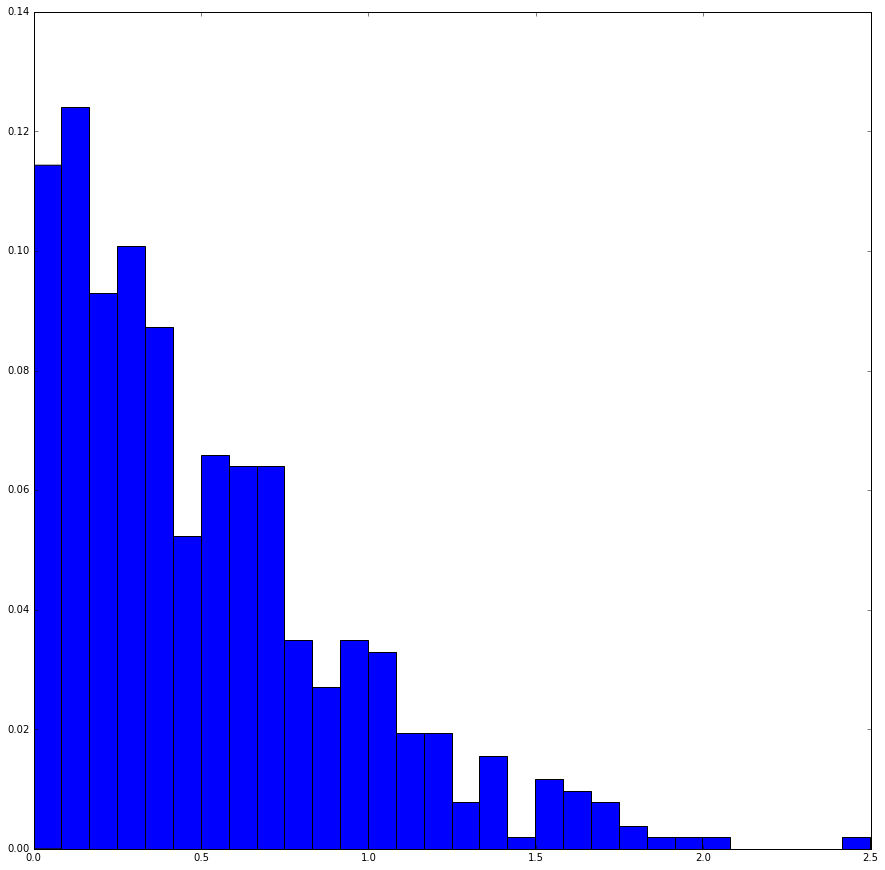

In [18]:
errors = (data_test.ic50 - model.predict(descriptors_test)).abs()
weights = np.ones_like(errors) / len(errors)
plt.hist(errors, weights=weights, bins=30)
plt.show()

### PCA Analysis

Let's now project our dataset to 3D space using PCA and see if there is any correlation between the postion of molecules and the pIC50 value:

(1327, 44)


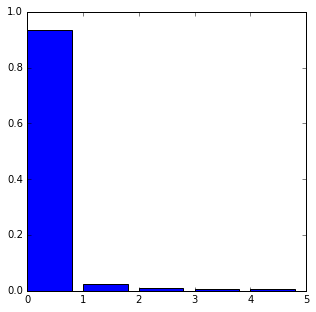

In [19]:
from sklearn import decomposition

n_components = 5
all_data = data.loc[:,data_train.columns]
ic50s =  all_data['ic50']
del all_data['ic50']
print(all_data.shape)

pca = decomposition.PCA(n_components=n_components)
pca.fit(all_data)
pca_result = pca.transform(all_data)
eigen_values = pca.explained_variance_ratio_

plt.rcParams["figure.figsize"] = [5, 5]
plt.bar(range(pca_result.shape[1]), eigen_values)
plt.show()

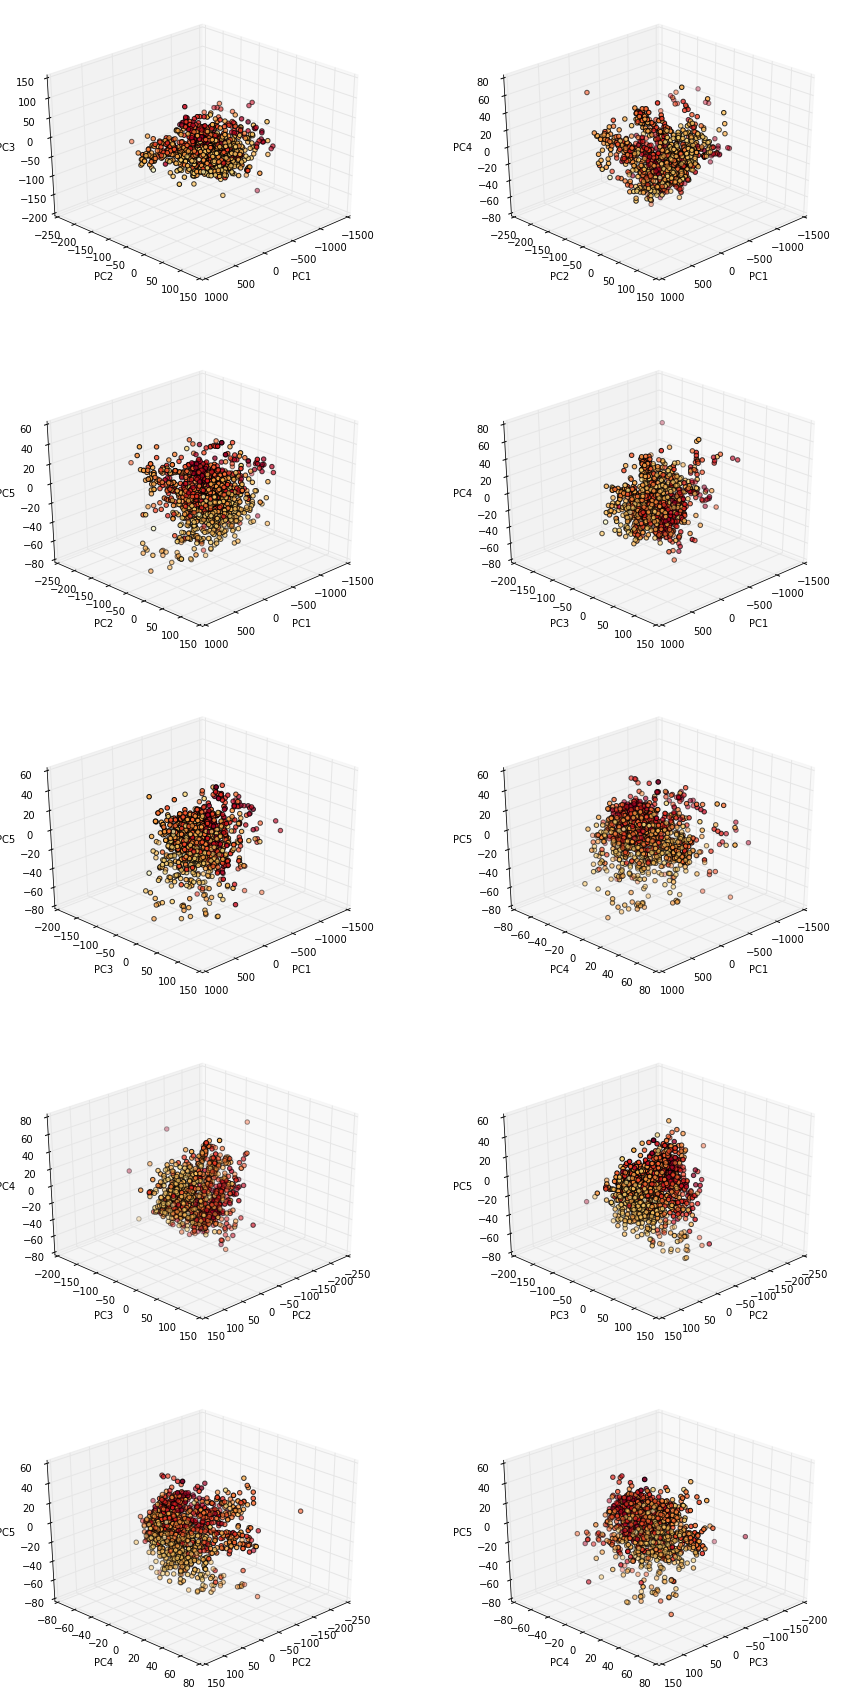

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations

combos = list(combinations(range(n_components), 3))

plt.rcParams["figure.figsize"] = [15, 30]
fig = plt.figure(len(combos) / 2)

for idx, combo in enumerate(combos):
    ax = fig.add_subplot(len(combos) / 2, 2, idx + 1, projection='3d')
    ax.scatter(
        pca_result[:,combo[0]]
        , pca_result[:,combo[1]]
        , pca_result[:,combo[2]]
        , c=ic50s
        , s=20
        , cmap='YlOrRd' # red are the compounds with higher values of pIC50
    )
    ax.view_init(elev=30, azim=45)
    ax.set_xlabel('PC%s' % (combo[0] + 1))
    ax.set_ylabel('PC%s' % (combo[1] + 1))
    ax.set_zlabel('PC%s' % (combo[2] + 1))

plt.show()

## Building a Random Forest Model

In this part of the notebook, we build a QSAR model using a random forest estimator from the [h2o](http://www.h2o.ai/) package. We will use the same training and testing dataset as in the SVR approach above:

In [ ]:
# from h2o.estimators.random_forest import H2ORandomForestEstimator as RFE

# model = RFE(
#     model_id = "random_forest_model"
# #      , mtries=-1
# #      , sample_rate=0.666
# #      , sample_rate_per_class=[]
# #      , col_sample_rate_per_tree=1
# #      , col_sample_rate_change_per_level=1
# #      , build_tree_one_node=False
# #      , ntrees=50
# #      , max_depth=20
# #      , min_rows=1
# #      , nbins=20
# #      , nbins_cats=1024
# #      , binomial_double_trees=False
# #      , balance_classes=False
#      , seed=SEED
#      , nfolds=CV_FOLDS
#      , fold_assignment="Random"
# #      , keep_cross_validation_predictions=False
# #      , keep_cross_validation_fold_assignment=False
# #      , score_each_iteration=False
# #      , score_tree_interval=0
# #      , stopping_rounds=0
# #      , stopping_metric="AUTO"
# #      , stopping_tolerance=0.001
# #      , min_split_improvement=0
# #      , histogram_type="AUTO"
# )
# model.train(
#     x=training_frame.names[2:]
#     , y='ic50'
#     , training_frame=training_frame
# )
# # model.show()

In [ ]:
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.random_forest import H2ORandomForestEstimator as RFE

parameters = {
    'ntrees' : [10, 50, 100, 150, 200]
    , 'max_depth' : [2, 4, 6, 8, 10, 20, 30]
    , 'col_sample_rate_per_tree' : [0.3, 0.6, 1.0]
    , 'sample_rate' : [0.3, 0.6, 1.0]
}
search_criteria = { 
    'strategy': "RandomDiscrete"
    , 'seed': SEED
    , 'stopping_metric': "MSE"
    , 'stopping_tolerance': 0.01
    , 'stopping_rounds': 5
}
grid_search = H2OGridSearch(
    RFE(
        seed=SEED
        , nfolds=CV_FOLDS
        , fold_assignment="Random"
    )
    , grid_id='grid_search'
    , hyper_params=parameters
    , search_criteria=search_criteria
)
grid_search.train(
    x=training_frame.names[2:]
    , y='ic50'
    , training_frame=training_frame
)

In [43]:
grid_search_results = grid_search.sort_by('mse')
best_model_id = grid_search_results['Model Id'][0]
best_model = h2o.get_model(best_model_id)
model = best_model
print(grid_search_results)
print(grid_search.get_hyperparams(best_model_id))


Grid Search Results for H2ORandomForestEstimator: 


Model Id,"Hyperparameters: [ntrees, col_sample_rate_per_tree, max_depth, sample_rate]",mse
grid_search_model_30,"[150, 0.3, 20, 0.6]",0.5405289
grid_search_model_89,"[200, 0.3, 20, 0.6]",0.5409457
grid_search_model_115,"[200, 1.0, 10, 0.6]",0.5466810
grid_search_model_10,"[150, 1.0, 20, 0.6]",0.5474221
grid_search_model_25,"[100, 0.3, 30, 0.6]",0.5483519
---,---,---
grid_search_model_14,"[50, 0.6, 2, 0.3]",0.8669788
grid_search_model_112,"[50, 1.0, 2, 0.6]",0.8698762
grid_search_model_55,"[50, 0.3, 2, 0.6]",0.8707005
grid_search_model_19,"[10, 1.0, 2, 0.3]",0.8838273



See the whole table with table.as_data_frame()

Hyperparameters: [ntrees, col_sample_rate_per_tree, max_depth, sample_rate]
[150, 0.3, 20, 0.6]


In [30]:
importances = model.varimp(use_pandas=True)
pickle.dump(importances, open('importances_rf.pickle', 'bw'))
importances.head()

,variable,relative_importance,scaled_importance,percentage
0,MinPartialCharge,22358.990234,1.000000,0.136486
1,MaxAbsPartialCharge,17239.359375,0.771026,0.105234
2,MolMR,8995.715820,0.402331,0.054913
3,fr_benzene,7659.498535,0.342569,0.046756
4,NumAromaticRings,6916.294922,0.309329,0.042219


### Cross-validation Results

In [31]:
performance = model.model_performance(xval=True)
print("R^2:", performance.r2())
print("R:", math.sqrt(performance.r2()))
print("MSE:", performance.mse())

R^2: 0.717400883087353
R: 0.8469952084205394
MSE: 0.5341122920660589


### Validation Set Results

In [32]:
performance = model.model_performance(test_data=testing_frame)
print("R^2:", performance.r2())
print("R:", math.sqrt(performance.r2()))
print("MSE:", performance.mse())

R^2: 0.7723377334416667
R: 0.8788274764944862
MSE: 0.4051800515405221


### Error plots

Finally, we take a look at the distribution of errors in predictions among the training set and the test set. We fetch and save the required data first:

In [33]:
from pandas import DataFrame

predictions_train = model.predict(training_frame).as_data_frame()
predictions_test = model.predict(testing_frame).as_data_frame()
predictions_train.columns = ['ic50']
predictions_test.columns = ['ic50']
true_values_train = training_frame['ic50'].as_data_frame()
true_values_test = testing_frame['ic50'].as_data_frame()

validation_predictions = DataFrame()
validation_predictions['ic50_predicted'] = predictions_test['ic50']
validation_predictions['ic50_true'] = true_values_test
validation_predictions.index = testing_frame['smiles'].as_data_frame()
pickle.dump(validation_predictions, open('validation_set_predictions_rf.pickle', 'wb'))
validation_predictions.head()

,ic50_predicted,ic50_true
"(CCc1c(O)ccc2c1O[C@H](c1ccc(OCCN3CCCCC3)cc1)[C@H](c1ccc(O)cc1)S2,)",7.952289,8.327902
"(COc1c(Br)c(O)c(Br)c2nc(-c3ccc(O)c(F)c3)oc12,)",5.705610,6.252588
"(Oc1ccc2nc(-c3ccc(O)c(F)c3)cc(Cl)c2c1,)",6.481460,6.609065
"(COc1cc(/C=C2\SC(=O)NC2=O)ccc1Oc1ccc(C#N)cc1C(F)(F)F,)",5.159806,5.657577
"(CCOC(=O)CSc1nn(C)c(=S)s1,)",4.674710,5.097820


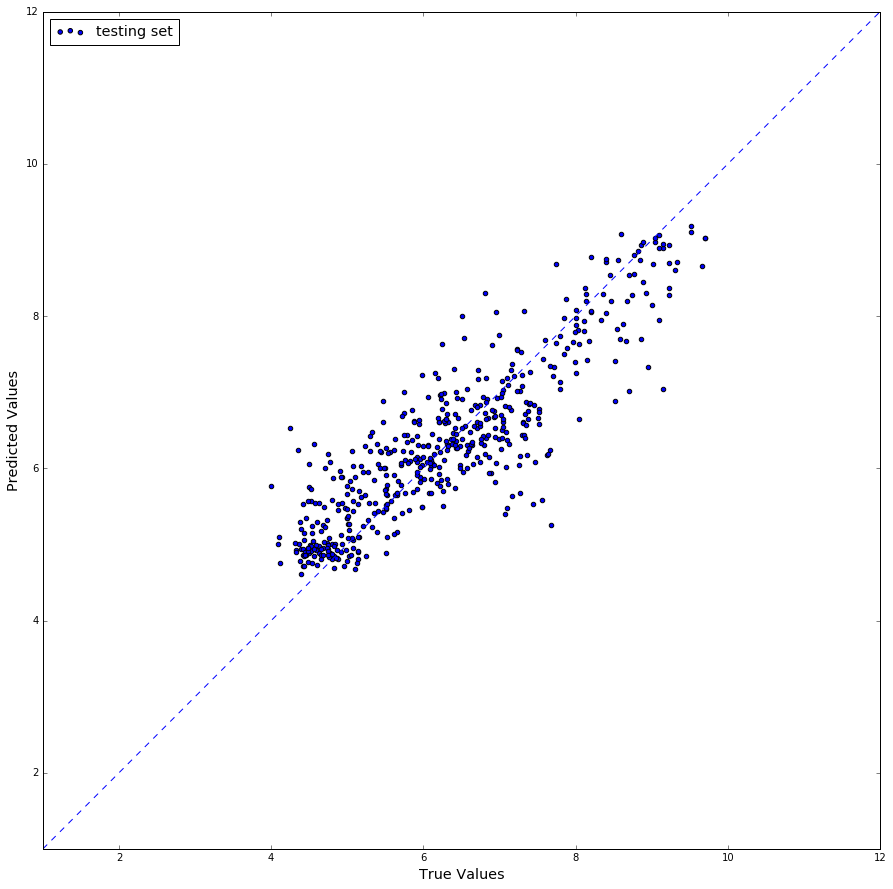

In [34]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 15]
span = (1,12)
axes = plt.gca()
axes.set_xlim(span)
axes.set_ylim(span)
axes.set_xlabel("True Values", fontsize='x-large')
axes.set_ylabel("Predicted Values", fontsize='x-large')

plt.plot((span[0],span[1]), (span[0],span[1]), linestyle='--')

# plt.scatter(
#     true_values_train
#     , predictions_train
#     , c='green'
#     , s=20
#     , label='training set'
# )

plt.scatter(
    true_values_test
    , predictions_test
    , c='blue'
    , s=20
    , label='testing set'
)

plt.legend(loc='upper left', fontsize='x-large')

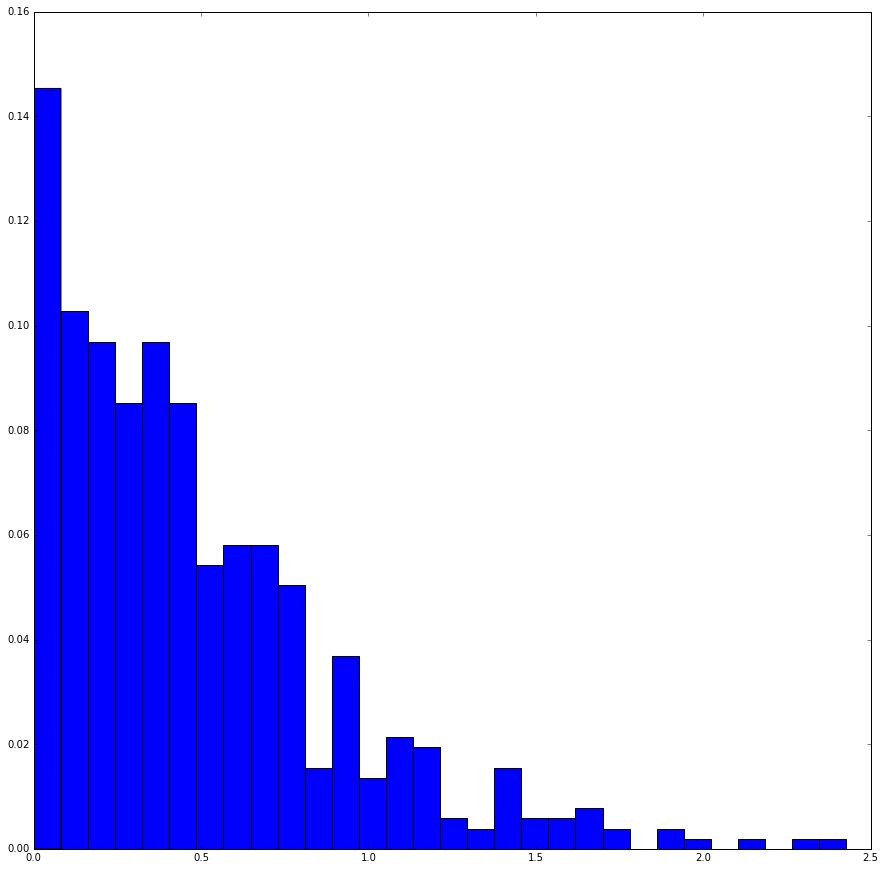

In [35]:
errors = (true_values_test - predictions_test).abs().iloc[:,0]
weights = np.ones_like(errors) / len(errors)
plt.hist(errors, weights=weights, bins=30)
plt.show()

## PCA Analysis

We can extract features that proved to be of high importance in the decision tree building, thus, should be most relevant to the activity-structure relationship. and project the molecules to 3D space and see if there is any correlation between their postion and the pIC50 value:

In [36]:
importances = model.varimp(use_pandas=True)
mask = importances["scaled_importance"] > 0.05
descs_important = data[importances["variable"][mask]]
print(descs_important.shape)
descs_important.head(10)

(1327, 38)


,MinPartialCharge,MaxAbsPartialCharge,MolMR,fr_benzene,NumAromaticRings,NumAromaticCarbocycles,MaxPartialCharge,Chi4v,BalabanJ,MolLogP,...,Chi1,MaxAbsEStateIndex,Chi2v,Chi2n,EState_VSA4,Chi3v,SlogP_VSA5,SlogP_VSA2,SlogP_VSA3,EState_VSA8
0,-0.507956,0.507956,148.3698,3,3,3,0.118883,5.964871,1.436100,6.70650,...,17.446545,10.188795,10.840129,10.840129,31.866728,8.147773,68.205388,42.792345,11.959747,85.168335
2,-0.507967,0.507967,139.7866,3,3,3,0.140270,6.254014,1.368494,6.49200,...,17.118525,10.412779,10.415686,9.232289,39.629618,8.230810,54.230461,41.354116,6.420822,17.032644
3,-0.507956,0.507956,136.3356,3,3,3,0.243451,6.681140,1.434939,4.51162,...,16.913853,13.740342,11.321261,9.430707,47.637587,8.887729,41.137290,55.515358,16.444113,4.899910
4,-0.507966,0.507966,73.0321,2,2,2,0.194032,2.455828,2.183659,3.22480,...,9.075387,12.401821,4.605885,4.605885,16.700008,3.409826,28.408629,15.996300,0.000000,0.000000
5,-0.507920,0.507920,121.0098,2,3,2,0.143093,5.497220,1.294169,5.81700,...,15.259153,9.863330,9.226556,8.043159,34.262962,7.173705,41.940068,36.247588,0.000000,17.032644
8,-0.507895,0.507895,82.4564,2,4,2,0.239157,3.020916,2.328321,3.57170,...,10.452397,12.512773,5.688143,4.833806,6.066367,3.983814,0.000000,15.319582,0.000000,15.929944
9,-0.507943,0.507943,80.2806,3,4,3,0.170701,2.587569,2.063442,4.05920,...,10.220347,9.724977,4.922655,4.922655,21.722124,3.576439,0.000000,15.369718,0.000000,5.156663
10,-0.507966,0.507966,69.7166,2,3,2,0.137489,2.076821,2.188698,3.81942,...,8.631030,9.552571,4.338544,4.338544,27.856395,2.938557,5.563451,10.213055,0.000000,0.000000
11,-0.507921,0.507921,82.7626,3,3,3,0.164917,2.405112,2.223360,4.70010,...,10.079719,13.477906,4.841227,4.841227,21.899351,3.471996,5.563451,10.213055,0.000000,6.578936
12,-0.507967,0.507967,136.3674,3,3,3,0.140005,5.996176,1.268789,5.14800,...,17.084851,9.943080,10.367958,9.184562,59.997323,8.128246,35.322451,53.067525,0.000000,4.899910


In [37]:
from sklearn import decomposition

n_components=5

pca = decomposition.PCA(n_components=n_components)
pca.fit(descs_important)
pca_result = pca.transform(descs_important)
eigen_values = pca.explained_variance_ratio_

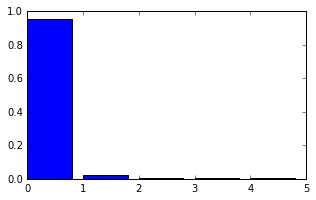

In [38]:
plt.rcParams["figure.figsize"] = [5, 3]

plt.bar(range(pca_result.shape[1]), eigen_values)
plt.show()

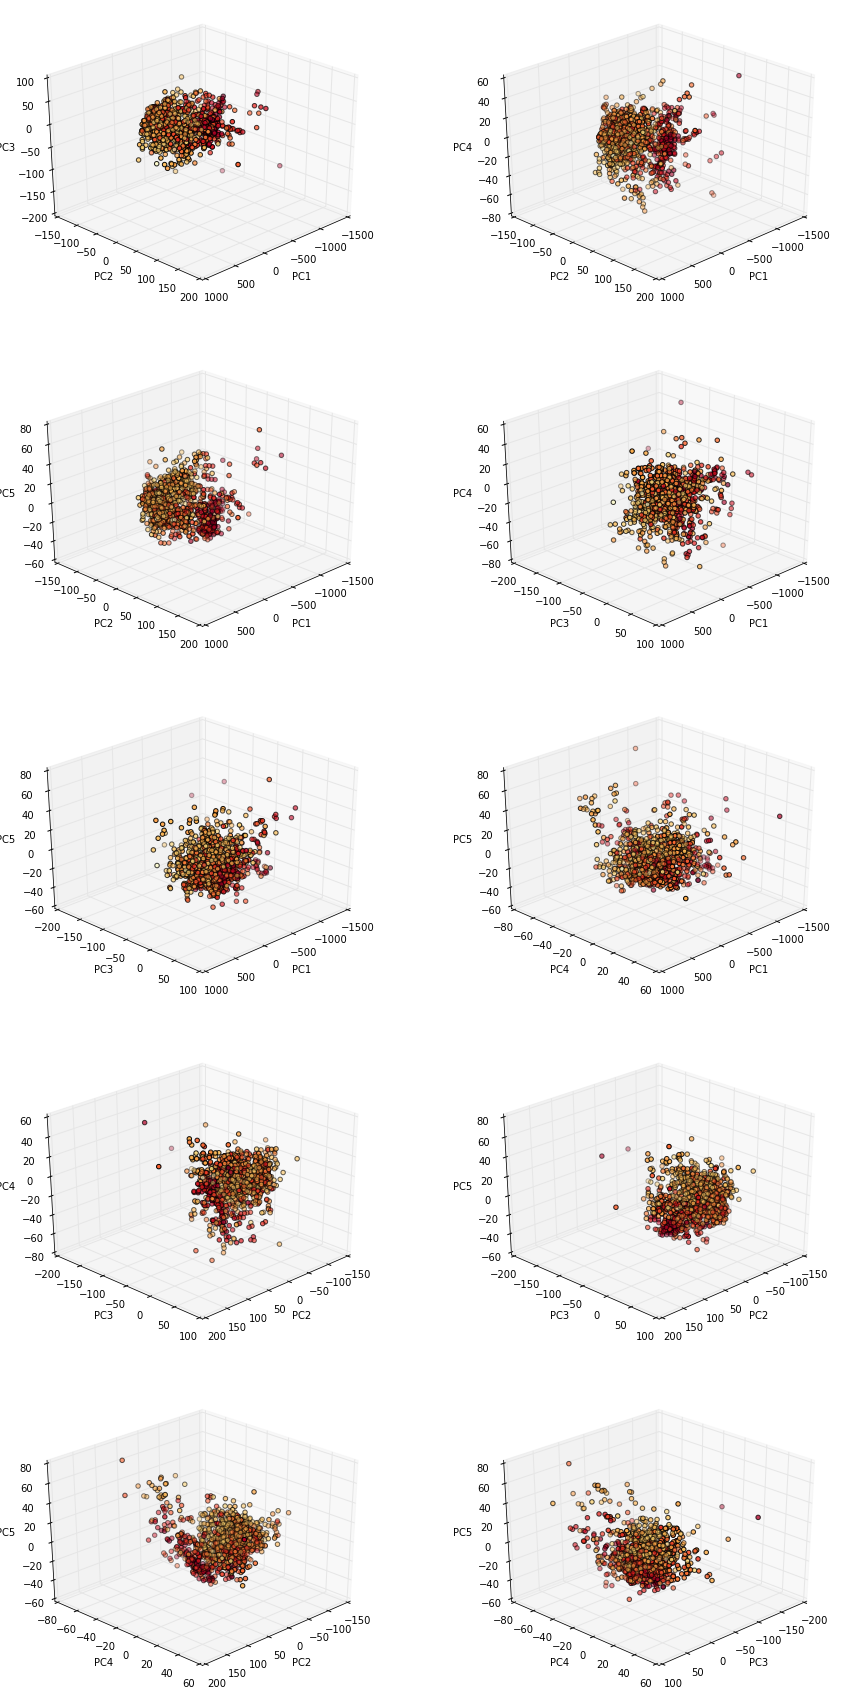

In [39]:
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations

combos = list(combinations(range(n_components), 3))

plt.rcParams["figure.figsize"] = [15, 30]
fig = plt.figure(len(combos) / 2)

for idx, combo in enumerate(combos):
    ax = fig.add_subplot(len(combos) / 2, 2, idx + 1, projection='3d')
    ax.scatter(
        pca_result[:,combo[0]]
        , pca_result[:,combo[1]]
        , pca_result[:,combo[2]]
        , c=data.ic50
        , s=20
        , cmap='YlOrRd' # red are the compounds with higher values of pIC50
    )
    ax.view_init(elev=30, azim=45)
    ax.set_xlabel('PC%s' % (combo[0] + 1))
    ax.set_ylabel('PC%s' % (combo[1] + 1))
    ax.set_zlabel('PC%s' % (combo[2] + 1))

plt.show()